## Baseline Model -- Facial Keypoint Prediction

In this notebook, we walk through a model from the tutorial referenced by the official Kaggle competition website. It was constructed by Daniel Nouri. We will use this model as the baseline of our final project.

### 0. Fire up Neural Nets Libraries

In [1]:
import os
import numpy as np
from pandas.io.parsers import read_csv
from pandas import DataFrame
from sklearn.utils import shuffle

import theano
from nolearn.lasagne import NeuralNet, TrainSplit
# nerual net layers definition
from lasagne import layers
# common gradient descent method
from lasagne.updates import nesterov_momentum
# for transforming images stochastically per batch on the fly
from nolearn.lasagne import BatchIterator

# for evaluating training time
from time import time
from datetime import datetime
# for storing and loading the trained models
import pickle

# for plotting images
import matplotlib.pyplot as plt
# for evaluating MSE
from sklearn.metrics import mean_squared_error

# Increase Python's recursion limit because the neural net model is large enough
import sys
sys.setrecursionlimit(10000)

from collections import OrderedDict
from sklearn.base import clone

try:
    from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayer
    from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayer
except ImportError:
    Conv2DLayer = layers.Conv2DLayer
    MaxPool2DLayer = layers.MaxPool2DLayer
    
np.random.seed(42)

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5110)
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 1. Data Path

We will further split the provided training data into our training set and development set in step 4.

In [2]:
FTRAIN = '~/data/training.csv'
FTEST = '~/data/test.csv'
FLOOKUP = '~/data/IdLookupTable.csv'

### 2. View Raw Data

In [24]:
# Each row of our data refers to one face. 
# The first 30 columns refers to the labels of different facial keypoints. 
# A feature vector in the last column store pixel values of the facial image.

read_csv(FTRAIN).head(1)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...


In [25]:
# Testing data has no targets available
read_csv(FTEST).head(1)

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...


### 3. Transforming Data

In [3]:
# Write function to load the data
# Normalize the target -- coordinates : current grid 96by96
# Normalize the features -- pixels : current range 255

def load(test = False, cols = None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN. 
    Pass a list of *cols* if you're only interested in a subset of the target columns"""
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname)) #Load pandas dataframe
    
    # The Image column has pixel values separated by space
    # convert these values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))
    
    if cols: # can selectively load some targets by specifying them in the cols argument
        df = df[list(cols) + ['Image']]
        
    print(df.count()) # prints the number of values for each column
    df = df.dropna() 
    # drop all rows that have missing values in them. 
    # if argument cols in not specified, this reduce from 7049 partial to 2140 full examples
    # potentially a problem training a neural net with fewer examples
    # should consider data augmentation in upcoming models
    
    # make feature matrix X
    # first convert pixel values from pandas 1D series to numpy 2D array
    # normalize pixel valuaes
    X = np.vstack(df['Image'].values)/255. # scale pixel values to [0,1]
    X = X.astype(np.float32) # make sure numeric val are float32
    # X is numpy.ndarray, shape (2140, 9216) == 2140 examples, 96 grid * 96 grid
    
    # Loading the 30 labels(targets)(keypoints) y for each face into an array
    if not test: # only training examples have target columns
        
        y = df[df.columns[:-1]].values #last column is X, we want the y targets here
        # y is numpy.ndarray, shape(2140, 30) -- 7049 examples, 30 targets each
        
        y = (y - 48) / 48 # scale target coordinates to [-1.1] (currently 96 by 96)
        X, y = shuffle(X, y, random_state = 42) #shuffle training data
        y = y.astype(np.float32)
        
    else:
        y = None # development data has no targets available
        
    return X,y

X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [4]:
# When using convolutional layers in Lasagne, we have to prepare the input data such 
# that each sample is no longer a flat vector of 9,216 pixel intensities, 
# but a three-dimensional matrix with shape (c, 0, 1), where c is the number of channels (colors), 
# and 0 and 1 correspond to the x and y dimensions of the input image. In our case, 
# the concrete shape will be (1, 96, 96), because we're dealing with a single (gray) color 
# channel only.

def load2d(test=False, cols=None):
    X, y = load(test=test)
    X = X.reshape(-1, 1, 96, 96)
    return X, y

X, y = load2d()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

### 4. Splitting into training and development set

In [5]:
from sklearn import model_selection
# help(model_selection.train_test_split)
# keep random state = 0 -- we need the same development set to compare our Baseline with other models
X_train, X_dev, y_train, y_dev, train_idx, test_idx = model_selection.train_test_split(X, y, range(len(X)), test_size=200, shuffle=True, random_state=0)
(X_train.shape, X_dev.shape, y_train.shape, y_dev.shape)

# There are 1940 training examples and 200 development examples

((1940, 1, 96, 96), (200, 1, 96, 96), (1940, 30), (200, 30))

In [6]:
# double check if random state is producing the same split
train_idx[100] == 1410

True

### 5. Data Augmentation -- functions to flipping half of the image on the fly

In [30]:
flip_indices = [
    (0, 2), (1, 3),
    (4, 8), (5, 9), (6, 10), (7, 11),
    (12, 16), (13, 17), (14, 18), (15, 19),
    (22, 24), (23, 25),
    ]

# Let's see if we got it right:
df = read_csv(os.path.expanduser(FTRAIN))
for i, j in flip_indices:
    print("# {} -> {}".format(df.columns[i], df.columns[j]))

# left_eye_center_x -> right_eye_center_x
# left_eye_center_y -> right_eye_center_y
# left_eye_inner_corner_x -> right_eye_inner_corner_x
# left_eye_inner_corner_y -> right_eye_inner_corner_y
# left_eye_outer_corner_x -> right_eye_outer_corner_x
# left_eye_outer_corner_y -> right_eye_outer_corner_y
# left_eyebrow_inner_end_x -> right_eyebrow_inner_end_x
# left_eyebrow_inner_end_y -> right_eyebrow_inner_end_y
# left_eyebrow_outer_end_x -> right_eyebrow_outer_end_x
# left_eyebrow_outer_end_y -> right_eyebrow_outer_end_y
# mouth_left_corner_x -> mouth_right_corner_x
# mouth_left_corner_y -> mouth_right_corner_y


In [7]:
class FlipBatchIterator(BatchIterator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0] #number of examples
        indices = np.random.choice(bs, bs // 2, replace=False) #choose half of them randomly
        Xb[indices] = Xb[indices, :, :, ::-1] #flip these guys randomly

        if yb is not None:
            # Horizontal flip of all x coordinates:
            yb[indices, ::2] = yb[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in self.flip_indices:
                yb[indices, a], yb[indices, b] = (
                    yb[indices, b], yb[indices, a])

        return Xb, yb

### 6. Adjust Variable -- function to update parameters such as learning rate and moment with epochs 

In [8]:
def float32(k):
    return np.cast['float32'](k)

In [9]:
class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

### 7. Early Stopping -- doesn't have to run max epochs once validation loss stablizes 

In [10]:
class EarlyStopping(object):
    def __init__(self, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()

### 8. Convolutional Neural Net Specification

In [11]:
net12 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', Conv2DLayer),
        ('pool1', MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('conv2', Conv2DLayer),
        ('pool2', MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        ('conv3', Conv2DLayer),
        ('pool3', MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,
    hidden4_num_units=1000,
    dropout4_p=0.5,
    hidden5_num_units=1000,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(patience=200),
        ],
    max_epochs=3000,
    verbose=1,
    )

X, y = load2d()

#vars(net12.train_split)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

### 9. Train and store the model

In [18]:
time0 = time()
net12.fit(X_train, y_train)
print(time()-time0)


with open('net12.pickle', 'wb') as f:
    pickle.dump(net12, f, -1)

# Neural Network with 16561502 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.06005     0.04213    1.42548  1.88s
      2     0.01520     0.02580    0.58926  1.86s
      3     0.01015     0.01914    0.53019  1.86s
      4     0.00831     0.01433    0.57966  1.87s
      5     0.00751     0.01143    0.65677  1.86s
      6     0.00715     0.01199    0.59595  1.86s
      7     0.00697     0.01067    0.65388  1.87s
      8     0.00677     0.01001    0.67552  1.86s
      9     0.00656     0.01031    0.63576  1.86s
     10    

    132     0.00431     0.00432    0.99608  1.86s
    133     0.00433     0.00434    0.99645  1.86s
    134     0.00431     0.00428    1.00782  1.85s
    135     0.00431     0.00428    1.00522  1.86s
    136     0.00429     0.00427    1.00401  1.86s
    137     0.00432     0.00422    1.02212  1.86s
    138     0.00430     0.00424    1.01391  1.86s
    139     0.00428     0.00422    1.01469  1.86s
    140     0.00429     0.00425    1.00830  1.86s
    141     0.00428     0.00425    1.00540  1.86s
    142     0.00429     0.00428    1.00340  1.86s
    143     0.00428     0.00420    1.02002  1.86s
    144     0.00426     0.00417    1.02252  1.86s
    145     0.00427     0.00418    1.02074  1.86s
    146     0.00426     0.00416    1.02496  1.86s
    147     0.00426     0.00415    1.02512  1.85s
    148     0.00424     0.00416    1.01956  1.86s
    149     0.00424     0.00411    1.03130  1.86s
    150     0.00424     0.00408    1.03795  1.86s
    151     0.00424     0.00414    1.02276  1.86s


    273     0.00353     0.00324    1.08920  1.86s
    274     0.00353     0.00322    1.09493  1.85s
    275     0.00353     0.00326    1.08523  1.85s
    276     0.00352     0.00321    1.09655  1.85s
    277     0.00351     0.00324    1.08375  1.85s
    278     0.00349     0.00325    1.07390  1.85s
    279     0.00350     0.00319    1.09596  1.85s
    280     0.00347     0.00321    1.08167  1.85s
    281     0.00350     0.00319    1.09608  1.85s
    282     0.00348     0.00321    1.08251  1.85s
    283     0.00346     0.00321    1.07932  1.85s
    284     0.00349     0.00315    1.10756  1.85s
    285     0.00345     0.00316    1.09179  1.85s
    286     0.00346     0.00317    1.09015  1.85s
    287     0.00344     0.00316    1.09061  1.85s
    288     0.00345     0.00313    1.10059  1.85s
    289     0.00343     0.00314    1.09199  1.85s
    290     0.00342     0.00310    1.10355  1.85s
    291     0.00344     0.00316    1.08981  1.85s
    292     0.00341     0.00309    1.10318  1.85s


    417     0.00271     0.00242    1.12256  1.87s
    418     0.00277     0.00242    1.14529  1.86s
    419     0.00275     0.00238    1.15416  1.87s
    420     0.00275     0.00238    1.15312  1.87s
    421     0.00276     0.00239    1.15164  1.85s
    422     0.00272     0.00239    1.13832  1.85s
    423     0.00276     0.00238    1.15584  1.86s
    424     0.00275     0.00239    1.14873  1.86s
    425     0.00272     0.00238    1.14416  1.86s
    426     0.00274     0.00241    1.13479  1.87s
    427     0.00271     0.00236    1.14841  1.86s
    428     0.00271     0.00237    1.14309  1.86s
    429     0.00270     0.00235    1.14696  1.85s
    430     0.00268     0.00238    1.12804  1.85s
    431     0.00272     0.00236    1.15603  1.86s
    432     0.00271     0.00236    1.14708  1.86s
    433     0.00270     0.00236    1.14225  1.85s
    434     0.00268     0.00235    1.14415  1.86s
    435     0.00268     0.00231    1.16337  1.87s
    436     0.00269     0.00236    1.13712  1.87s


    569     0.00237     0.00206    1.14834  1.85s
    570     0.00237     0.00203    1.16918  1.86s
    571     0.00236     0.00201    1.17309  1.85s
    572     0.00238     0.00205    1.16536  1.86s
    573     0.00239     0.00204    1.17180  1.86s
    574     0.00238     0.00204    1.16536  1.86s
    575     0.00234     0.00201    1.16554  1.86s
    576     0.00235     0.00204    1.15054  1.85s
    577     0.00235     0.00203    1.15874  1.86s
    578     0.00236     0.00201    1.17196  1.86s
    579     0.00235     0.00202    1.16463  1.85s
    580     0.00235     0.00205    1.14853  1.85s
    581     0.00235     0.00204    1.15121  1.85s
    582     0.00232     0.00201    1.15401  1.86s
    583     0.00236     0.00202    1.16727  1.86s
    584     0.00234     0.00203    1.15248  1.85s
    585     0.00233     0.00203    1.14500  1.86s
    586     0.00234     0.00205    1.14264  1.86s
    587     0.00233     0.00199    1.17495  1.86s
    588     0.00235     0.00201    1.16568  1.86s


    723     0.00212     0.00183    1.15831  1.85s
    724     0.00214     0.00181    1.17976  1.86s
    725     0.00212     0.00180    1.18130  1.85s
    726     0.00215     0.00184    1.16501  1.87s
    727     0.00212     0.00182    1.16607  1.86s
    728     0.00212     0.00181    1.17420  1.86s
    729     0.00212     0.00180    1.17851  1.85s
    730     0.00213     0.00181    1.17863  1.86s
    731     0.00213     0.00181    1.17967  1.86s
    732     0.00212     0.00180    1.17700  1.87s
    733     0.00213     0.00182    1.16917  1.87s
    734     0.00214     0.00180    1.18833  1.86s
    735     0.00213     0.00181    1.17774  1.86s
    736     0.00212     0.00182    1.16426  1.86s
    737     0.00213     0.00178    1.19848  1.87s
    738     0.00212     0.00180    1.18212  1.86s
    739     0.00214     0.00181    1.18357  1.86s
    740     0.00212     0.00181    1.16952  1.86s
    741     0.00210     0.00181    1.15894  1.86s
    742     0.00213     0.00178    1.19357  1.86s


    878     0.00198     0.00166    1.19049  1.85s
    879     0.00197     0.00166    1.18404  1.85s
    880     0.00196     0.00167    1.17726  1.86s
    881     0.00197     0.00165    1.19072  1.86s
    882     0.00196     0.00164    1.19515  1.86s
    883     0.00200     0.00165    1.20720  1.85s
    884     0.00196     0.00166    1.18497  1.86s
    885     0.00196     0.00165    1.19031  1.86s
    886     0.00194     0.00166    1.17007  1.85s
    887     0.00195     0.00166    1.17996  1.85s
    888     0.00198     0.00165    1.19752  1.86s
    889     0.00197     0.00168    1.17381  1.86s
    890     0.00197     0.00165    1.19707  1.85s
    891     0.00196     0.00165    1.18634  1.87s
    892     0.00194     0.00166    1.16802  1.85s
    893     0.00194     0.00165    1.17809  1.86s
    894     0.00195     0.00165    1.18043  1.86s
    895     0.00197     0.00164    1.19826  1.85s
    896     0.00195     0.00164    1.18839  1.86s
    897     0.00197     0.00166    1.18351  1.85s


   1035     0.00183     0.00154    1.19362  1.85s
   1036     0.00184     0.00155    1.18690  1.86s
   1037     0.00183     0.00154    1.19255  1.86s
   1038     0.00183     0.00156    1.17314  1.85s
   1039     0.00183     0.00154    1.18796  1.86s
   1040     0.00183     0.00154    1.18836  1.85s
   1041     0.00183     0.00152    1.20455  1.85s
   1042     0.00185     0.00154    1.19740  1.86s
   1043     0.00185     0.00154    1.20349  1.86s
   1044     0.00186     0.00153    1.21587  1.86s
   1045     0.00184     0.00154    1.19836  1.85s
   1046     0.00186     0.00154    1.20519  1.86s
   1047     0.00185     0.00153    1.20939  1.86s
   1048     0.00182     0.00153    1.18991  1.86s
   1049     0.00183     0.00152    1.20449  1.85s
   1050     0.00184     0.00154    1.19753  1.85s
   1051     0.00183     0.00153    1.19642  1.86s
   1052     0.00181     0.00153    1.17888  1.85s
   1053     0.00184     0.00154    1.19406  1.86s
   1054     0.00183     0.00153    1.19595  1.85s


   1194     0.00176     0.00145    1.21229  1.85s
   1195     0.00174     0.00145    1.20013  1.86s
   1196     0.00174     0.00144    1.20754  1.86s
   1197     0.00176     0.00145    1.21642  1.85s
   1198     0.00174     0.00145    1.20504  1.85s
   1199     0.00173     0.00145    1.19599  1.85s
   1200     0.00172     0.00145    1.18941  1.86s
   1201     0.00173     0.00144    1.20111  1.85s
   1202     0.00174     0.00145    1.19805  1.85s
   1203     0.00174     0.00145    1.19983  1.85s
   1204     0.00175     0.00146    1.20228  1.85s
   1205     0.00173     0.00145    1.19745  1.86s
   1206     0.00173     0.00145    1.19498  1.86s
   1207     0.00175     0.00145    1.20362  1.86s
   1208     0.00176     0.00145    1.20976  1.86s
   1209     0.00173     0.00145    1.19206  1.86s
   1210     0.00173     0.00144    1.19516  1.86s
   1211     0.00175     0.00145    1.20997  1.86s
   1212     0.00172     0.00145    1.18790  1.86s
   1213     0.00172     0.00144    1.19267  1.85s


   1352     0.00166     0.00139    1.19776  1.86s
   1353     0.00165     0.00137    1.20701  1.86s
   1354     0.00167     0.00139    1.20046  1.85s
   1355     0.00164     0.00137    1.19589  1.86s
   1356     0.00166     0.00138    1.20343  1.85s
   1357     0.00165     0.00138    1.20111  1.85s
   1358     0.00166     0.00137    1.20783  1.85s
   1359     0.00164     0.00138    1.19307  1.85s
   1360     0.00165     0.00138    1.19571  1.85s
   1361     0.00166     0.00138    1.20782  1.86s
   1362     0.00164     0.00138    1.19215  1.86s
   1363     0.00167     0.00137    1.22039  1.86s
   1364     0.00168     0.00137    1.23017  1.85s
   1365     0.00165     0.00137    1.20247  1.85s
   1366     0.00164     0.00138    1.18933  1.85s
   1367     0.00166     0.00138    1.20579  1.85s
   1368     0.00166     0.00137    1.21187  1.85s
   1369     0.00167     0.00138    1.21483  1.87s
   1370     0.00166     0.00137    1.21415  1.85s
   1371     0.00164     0.00138    1.18957  1.85s


   1510     0.00161     0.00132    1.22352  1.86s
   1511     0.00158     0.00132    1.19874  1.86s
   1512     0.00158     0.00133    1.19569  1.86s
   1513     0.00160     0.00133    1.20024  1.86s
   1514     0.00161     0.00132    1.21391  1.86s
   1515     0.00160     0.00131    1.21585  1.86s
   1516     0.00158     0.00132    1.19631  1.86s
   1517     0.00159     0.00132    1.20917  1.86s
   1518     0.00159     0.00132    1.19954  1.86s
   1519     0.00160     0.00133    1.20646  1.86s
   1520     0.00160     0.00132    1.21282  1.86s
   1521     0.00158     0.00132    1.20119  1.87s
   1522     0.00158     0.00132    1.20323  1.86s
   1523     0.00159     0.00132    1.20514  1.86s
   1524     0.00159     0.00132    1.20836  1.86s
   1525     0.00157     0.00132    1.19440  1.86s
   1526     0.00158     0.00131    1.20281  1.86s
   1527     0.00159     0.00132    1.20370  1.86s
   1528     0.00159     0.00132    1.20507  1.86s
   1529     0.00159     0.00132    1.20620  1.86s


   1668     0.00153     0.00127    1.20346  1.86s
   1669     0.00152     0.00127    1.19758  1.86s
   1670     0.00151     0.00128    1.17778  1.87s
   1671     0.00154     0.00128    1.20044  1.86s
   1672     0.00154     0.00127    1.21483  1.86s
   1673     0.00153     0.00128    1.19387  1.86s
   1674     0.00153     0.00127    1.20380  1.86s
   1675     0.00152     0.00128    1.19541  1.86s
   1676     0.00154     0.00130    1.18776  1.86s
   1677     0.00153     0.00127    1.20523  1.87s
   1678     0.00155     0.00127    1.22091  1.86s
   1679     0.00153     0.00128    1.19236  1.86s
   1680     0.00154     0.00127    1.20616  1.86s
   1681     0.00151     0.00129    1.17396  1.86s
   1682     0.00153     0.00126    1.21349  1.86s
   1683     0.00155     0.00127    1.21675  1.86s
   1684     0.00153     0.00127    1.20132  1.86s
   1685     0.00152     0.00127    1.19858  1.86s
   1686     0.00154     0.00127    1.21357  1.87s
   1687     0.00154     0.00127    1.21156  1.86s


   1826     0.00148     0.00124    1.19999  1.86s
   1827     0.00147     0.00123    1.19448  1.86s
   1828     0.00149     0.00123    1.20887  1.86s
   1829     0.00151     0.00124    1.21984  1.86s
   1830     0.00147     0.00124    1.19103  1.86s
   1831     0.00147     0.00124    1.18556  1.86s
   1832     0.00147     0.00122    1.20680  1.86s
   1833     0.00149     0.00123    1.21605  1.86s
   1834     0.00148     0.00123    1.20071  1.86s
   1835     0.00148     0.00122    1.20538  1.86s
   1836     0.00144     0.00123    1.16869  1.86s
   1837     0.00148     0.00123    1.19563  1.86s
   1838     0.00147     0.00122    1.19789  1.86s
   1839     0.00147     0.00122    1.19890  1.87s
   1840     0.00148     0.00124    1.19793  1.86s
   1841     0.00147     0.00122    1.19693  1.86s
   1842     0.00147     0.00122    1.19931  1.86s
   1843     0.00149     0.00124    1.20128  1.86s
   1844     0.00147     0.00123    1.20080  1.86s
   1845     0.00147     0.00123    1.19591  1.86s


   1986     0.00145     0.00120    1.20417  1.86s
   1987     0.00144     0.00120    1.20297  1.86s
   1988     0.00142     0.00119    1.19542  1.86s
   1989     0.00143     0.00119    1.20085  1.86s
   1990     0.00143     0.00120    1.19597  1.87s
   1991     0.00143     0.00120    1.19199  1.87s
   1992     0.00143     0.00120    1.19493  1.86s
   1993     0.00144     0.00120    1.20626  1.86s
   1994     0.00141     0.00120    1.17449  1.86s
   1995     0.00145     0.00119    1.21787  1.86s
   1996     0.00142     0.00120    1.18895  1.86s
   1997     0.00145     0.00121    1.20054  1.86s
   1998     0.00143     0.00119    1.20663  1.86s
   1999     0.00142     0.00119    1.19828  1.86s
   2000     0.00142     0.00120    1.18906  1.87s
   2001     0.00144     0.00119    1.20798  1.86s
   2002     0.00144     0.00119    1.20903  1.86s
   2003     0.00146     0.00119    1.22569  1.86s
   2004     0.00144     0.00120    1.20220  1.86s
   2005     0.00143     0.00119    1.19991  1.86s


   2146     0.00140     0.00116    1.20536  1.86s
   2147     0.00140     0.00116    1.20587  1.86s
   2148     0.00139     0.00117    1.18916  1.87s
   2149     0.00141     0.00117    1.20394  1.86s
   2150     0.00138     0.00116    1.19106  1.86s
   2151     0.00138     0.00116    1.19424  1.86s
   2152     0.00140     0.00117    1.20196  1.86s
   2153     0.00141     0.00116    1.21512  1.86s
   2154     0.00139     0.00115    1.20160  1.86s
   2155     0.00141     0.00115    1.21904  1.86s
   2156     0.00141     0.00116    1.21336  1.86s
   2157     0.00139     0.00117    1.19001  1.86s
   2158     0.00138     0.00116    1.18617  1.86s
   2159     0.00138     0.00116    1.19799  1.86s
   2160     0.00139     0.00116    1.19704  1.86s
   2161     0.00140     0.00116    1.20589  1.86s
   2162     0.00140     0.00116    1.20027  1.86s
   2163     0.00139     0.00116    1.19807  1.86s
   2164     0.00140     0.00117    1.19775  1.86s
   2165     0.00138     0.00116    1.19151  1.86s


   2306     0.00136     0.00113    1.19814  1.86s
   2307     0.00136     0.00113    1.20374  1.86s
   2308     0.00135     0.00113    1.20212  1.86s
   2309     0.00135     0.00112    1.20124  1.86s
   2310     0.00135     0.00113    1.19030  1.86s
   2311     0.00135     0.00114    1.18529  1.86s
   2312     0.00136     0.00113    1.20601  1.86s
   2313     0.00137     0.00113    1.21284  1.86s
   2314     0.00135     0.00113    1.18942  1.86s
   2315     0.00134     0.00113    1.18199  1.86s
   2316     0.00134     0.00113    1.19027  1.86s
   2317     0.00134     0.00113    1.18967  1.86s
   2318     0.00133     0.00112    1.18535  1.86s
   2319     0.00134     0.00113    1.18603  1.86s
   2320     0.00135     0.00115    1.17542  1.86s
   2321     0.00134     0.00114    1.17615  1.86s
   2322     0.00135     0.00113    1.19333  1.87s
   2323     0.00134     0.00113    1.18406  1.86s
   2324     0.00132     0.00114    1.16435  1.86s
   2325     0.00134     0.00113    1.18266  1.86s


   2466     0.00132     0.00111    1.19468  1.86s
   2467     0.00133     0.00111    1.19863  1.86s
   2468     0.00132     0.00111    1.19246  1.86s
   2469     0.00132     0.00111    1.18647  1.86s
   2470     0.00133     0.00111    1.19264  1.86s
   2471     0.00133     0.00111    1.20532  1.86s
   2472     0.00132     0.00110    1.19661  1.86s
   2473     0.00131     0.00111    1.18211  1.86s
   2474     0.00131     0.00111    1.17902  1.86s
   2475     0.00132     0.00111    1.18946  1.86s
   2476     0.00132     0.00110    1.19695  1.86s
   2477     0.00132     0.00110    1.19332  1.86s
   2478     0.00131     0.00111    1.18493  1.86s
   2479     0.00132     0.00111    1.19411  1.86s
   2480     0.00131     0.00110    1.18508  1.86s
   2481     0.00132     0.00110    1.19896  1.86s
   2482     0.00133     0.00110    1.20772  1.86s
   2483     0.00132     0.00111    1.19143  1.86s
   2484     0.00131     0.00111    1.18487  1.86s
   2485     0.00131     0.00111    1.18140  1.86s


   2627     0.00131     0.00109    1.20370  1.87s
   2628     0.00126     0.00108    1.16406  1.87s
   2629     0.00129     0.00108    1.19289  1.86s
   2630     0.00128     0.00109    1.17955  1.87s
   2631     0.00128     0.00109    1.17255  1.86s
   2632     0.00128     0.00109    1.17265  1.86s
   2633     0.00129     0.00109    1.19015  1.86s
   2634     0.00130     0.00108    1.20090  1.87s
   2635     0.00128     0.00108    1.18527  1.86s
   2636     0.00129     0.00108    1.19283  1.86s
   2637     0.00130     0.00108    1.20373  1.86s
   2638     0.00129     0.00108    1.19430  1.86s
   2639     0.00128     0.00109    1.18003  1.86s
   2640     0.00128     0.00109    1.18381  1.86s
   2641     0.00129     0.00108    1.19056  1.86s
   2642     0.00129     0.00108    1.20004  1.86s
   2643     0.00127     0.00108    1.18033  1.86s
   2644     0.00129     0.00108    1.19500  1.88s
   2645     0.00128     0.00108    1.17785  1.86s
   2646     0.00128     0.00108    1.18622  1.86s


   2787     0.00126     0.00107    1.18495  1.86s
   2788     0.00126     0.00106    1.18843  1.86s
   2789     0.00127     0.00106    1.19634  1.86s
   2790     0.00125     0.00106    1.17860  1.86s
   2791     0.00127     0.00106    1.19315  1.86s
   2792     0.00126     0.00106    1.18258  1.86s
   2793     0.00125     0.00106    1.17778  1.86s
   2794     0.00123     0.00106    1.15810  1.86s
   2795     0.00126     0.00106    1.18564  1.86s
   2796     0.00127     0.00106    1.19867  1.86s
   2797     0.00126     0.00106    1.18719  1.87s
   2798     0.00126     0.00106    1.18869  1.86s
   2799     0.00126     0.00106    1.18972  1.86s
   2800     0.00125     0.00106    1.17583  1.86s
   2801     0.00124     0.00106    1.16444  1.86s
   2802     0.00126     0.00107    1.18040  1.86s
   2803     0.00126     0.00107    1.17795  1.86s
   2804     0.00126     0.00107    1.18480  1.86s
   2805     0.00126     0.00107    1.18453  1.86s
   2806     0.00125     0.00106    1.17157  1.86s


   2947     0.00124     0.00105    1.18030  1.87s
   2948     0.00124     0.00105    1.17741  1.87s
   2949     0.00124     0.00105    1.17433  1.86s
   2950     0.00124     0.00105    1.17318  1.86s
   2951     0.00122     0.00105    1.16006  1.86s
   2952     0.00124     0.00105    1.17984  1.86s
   2953     0.00124     0.00105    1.18868  1.86s
   2954     0.00124     0.00104    1.18423  1.86s
   2955     0.00124     0.00104    1.18538  1.86s
   2956     0.00124     0.00104    1.18844  1.86s
   2957     0.00123     0.00104    1.17877  1.86s
   2958     0.00125     0.00104    1.19671  1.87s
   2959     0.00122     0.00104    1.17134  1.86s
   2960     0.00123     0.00105    1.17811  1.86s
   2961     0.00123     0.00105    1.17836  1.86s
   2962     0.00123     0.00105    1.17317  1.86s
   2963     0.00123     0.00105    1.16868  1.87s
   2964     0.00123     0.00105    1.16913  1.86s
   2965     0.00124     0.00105    1.18311  1.86s
   2966     0.00123     0.00105    1.17299  1.87s


### 9.5 Load the Pickle 
(if net is train already)

In [12]:
fname_pretrain = 'net12.pickle'
with open(fname_pretrain, 'rb') as f:  # !
    net_pretrain = pickle.load(f)

In [16]:
net_pretrain.save_params_to('net_pretrain_saved_params.txt')

### 9.6 Create Specialists Dictionary

In [13]:
SPECIALIST_SETTINGS = [
    dict(
        columns=(
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'nose_tip_x', 'nose_tip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),

    dict(
        columns=(
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),
    ]

### 9.7 Train Specialists 

In [39]:
specialists = OrderedDict()

for setting in SPECIALIST_SETTINGS:
    cols = setting['columns']
    X, y = load2d(cols=cols)

    model = clone(net12)
    model.output_num_units = y.shape[1]
    model.batch_iterator_train.flip_indices = setting['flip_indices']
    model.max_epochs = int(4e6 / y.shape[0])
    if 'kwargs' in setting:
        # an option 'kwargs' in the settings list may be used to
        # set any other parameter of the net:
        vars(model).update(setting['kwargs'])

    if net_pretrain is not None:
        # if a pretrain model was given, use it to initialize the
        # weights of our new specialist model:
        model.load_params_from(net_pretrain)

    print("Training model for columns {} for {} epochs".format(cols, model.max_epochs))
    model.fit(X_train, y_train)
    specialists[cols] = model

with open('net-specialists.pickle', 'wb') as f:
    # this time we're persisting a dictionary with all models:
    pickle.dump(specialists, f, -1)


left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

Loaded parameters to layer 'conv1' (shape 32x1x3x3).
Loaded parameters to layer 'conv1' (shape 32).
Loaded parameters to layer 'conv2' (shape 64x32x2x2).
Loaded parameters to layer 'conv2' (shape 64).
Loaded parameters to layer 'conv3' (shape 128x64x2x2).
Loaded parameters to layer 'conv3' (shape 128).
Loaded parameters to layer 'hidden4' (shape 15488x1000).
Loaded parameters to layer 'hidden4' (shape 1000).
Loaded parameters to layer 'hidden5' (shape 1000x1000).
Loaded parameters to layer 'hidden5' (shape 1000).
Loaded parameters to layer 'output' (shape 1000x30).
Loaded parameters to layer 'output' (shape 30).
Training model for columns ('left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y') for 1869 epochs
# Neural Network with 16561502 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2 

     56     0.04859     0.04328    1.12270  1.86s
     57     0.04776     0.05185    0.92100  1.86s
     57     0.04776     0.05185    0.92100  1.86s
     58     0.04755     0.04769    0.99696  1.86s
     58     0.04755     0.04769    0.99696  1.86s
     59     0.04707     0.04783    0.98413  1.86s
     59     0.04707     0.04783    0.98413  1.86s
     60     0.04620     0.03739    1.23551  1.86s
     60     0.04620     0.03739    1.23551  1.86s
     61     0.04624     0.04384    1.05481  1.86s
     61     0.04624     0.04384    1.05481  1.86s
     62     0.04518     0.04052    1.11509  1.86s
     62     0.04518     0.04052    1.11509  1.86s
     63     0.04548     0.05356    0.84916  1.86s
     63     0.04548     0.05356    0.84916  1.86s
     64     0.04438     0.03678    1.20660  1.86s
     64     0.04438     0.03678    1.20660  1.86s
     65     0.04406     0.04474    0.98470  1.86s
     65     0.04406     0.04474    0.98470  1.86s
     66     0.04342     0.03627    1.19696  1.86s


    129     0.02700     0.02441    1.10621  1.86s
    129     0.02700     0.02441    1.10621  1.86s
    130     0.02726     0.02325    1.17241  1.86s
    130     0.02726     0.02325    1.17241  1.86s
    131     0.02692     0.02790    0.96495  1.86s
    131     0.02692     0.02790    0.96495  1.86s
    132     0.02677     0.02715    0.98612  1.86s
    132     0.02677     0.02715    0.98612  1.86s
    133     0.02695     0.02769    0.97350  1.86s
    133     0.02695     0.02769    0.97350  1.86s
    134     0.02666     0.02574    1.03580  1.86s
    134     0.02666     0.02574    1.03580  1.86s
    135     0.02624     0.02619    1.00204  1.86s
    135     0.02624     0.02619    1.00204  1.86s
    136     0.02673     0.02383    1.12157  1.86s
    136     0.02673     0.02383    1.12157  1.86s
    137     0.02674     0.02654    1.00723  1.87s
    137     0.02674     0.02654    1.00723  1.87s
    138     0.02749     0.02603    1.05585  1.87s
    138     0.02749     0.02603    1.05585  1.87s


    206     0.01877     0.02776    0.67601  1.86s
    206     0.01877     0.02776    0.67601  1.86s
    207     0.01828     0.02032    0.89995  1.86s
    207     0.01828     0.02032    0.89995  1.86s
    208     0.01884     0.02212    0.85131  1.86s
    208     0.01884     0.02212    0.85131  1.86s
    209     0.01789     0.02347    0.76238  1.87s
    209     0.01789     0.02347    0.76238  1.87s
    210     0.01807     0.02475    0.73021  1.87s
    210     0.01807     0.02475    0.73021  1.87s
    211     0.01804     0.02312    0.78042  1.87s
    211     0.01804     0.02312    0.78042  1.87s
    212     0.01817     0.02458    0.73928  1.86s
    212     0.01817     0.02458    0.73928  1.86s
    213     0.01748     0.02172    0.80497  1.86s
    213     0.01748     0.02172    0.80497  1.86s
    214     0.01699     0.02294    0.74075  1.86s
    214     0.01699     0.02294    0.74075  1.86s
    215     0.01725     0.02379    0.72510  1.86s
    215     0.01725     0.02379    0.72510  1.86s


    285     0.01303     0.02272    0.57320  1.86s
    285     0.01303     0.02272    0.57320  1.86s
    286     0.01265     0.02086    0.60659  1.86s
    286     0.01265     0.02086    0.60659  1.86s
    287     0.01258     0.02390    0.52660  1.86s
    287     0.01258     0.02390    0.52660  1.86s
    288     0.01224     0.02357    0.51915  1.86s
    288     0.01224     0.02357    0.51915  1.86s
    289     0.01240     0.02189    0.56641  1.86s
    289     0.01240     0.02189    0.56641  1.86s
    290     0.01234     0.02187    0.56415  1.86s
    290     0.01234     0.02187    0.56415  1.86s
    291     0.01193     0.02516    0.47425  1.86s
    291     0.01193     0.02516    0.47425  1.86s
    292     0.01202     0.02375    0.50607  1.86s
    292     0.01202     0.02375    0.50607  1.86s
    293     0.01225     0.02463    0.49728  1.86s
    293     0.01225     0.02463    0.49728  1.86s
    294     0.01189     0.02315    0.51347  1.86s
    294     0.01189     0.02315    0.51347  1.86s


    364     0.00874     0.02214    0.39452  1.86s
    365     0.00973     0.02404    0.40476  1.86s
    365     0.00973     0.02404    0.40476  1.86s
    366     0.00957     0.02172    0.44082  1.87s
    366     0.00957     0.02172    0.44082  1.87s
    367     0.00910     0.02345    0.38782  1.86s
    367     0.00910     0.02345    0.38782  1.86s
    368     0.00890     0.02244    0.39673  1.87s
    368     0.00890     0.02244    0.39673  1.87s
    369     0.00933     0.02248    0.41482  1.87s
    369     0.00933     0.02248    0.41482  1.87s
    370     0.00940     0.02563    0.36659  1.86s
    370     0.00940     0.02563    0.36659  1.86s
    371     0.00928     0.02107    0.44031  1.86s
    371     0.00928     0.02107    0.44031  1.86s
    372     0.00876     0.02577    0.34009  1.86s
    372     0.00876     0.02577    0.34009  1.86s
    373     0.00888     0.02224    0.39937  1.86s
    373     0.00888     0.02224    0.39937  1.86s
    374     0.00921     0.02265    0.40681  1.86s


/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

Loaded parameters to layer 'conv1' (shape 32x1x3x3).
Loaded parameters to layer 'conv1' (shape 32).
Loaded parameters to layer 'conv2' (shape 64x32x2x2).
Loaded parameters to layer 'conv2' (shape 64).
Loaded parameters to layer 'conv3' (shape 128x64x2x2).
Loaded parameters to layer 'conv3' (shape 128).
Loaded parameters to layer 'hidden4' (shape 15488x1000).
Loaded parameters to layer 'hidden4' (shape 1000).
Loaded parameters to layer 'hidden5' (shape 1000x1000).
Loaded parameters to layer 'hidden5' (shape 1000).
Loaded parameters to layer 'output' (shape 1000x30).
Loaded parameters to layer 'output' (shape 30).
Training model for columns ('nose_tip_x', 'nose_tip_y') for 1869 epochs
# Neural Network with 16561502 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22

     57     0.05171     0.05200    0.99450  1.86s
     57     0.05171     0.05200    0.99450  1.86s
     58     0.05168     0.05535    0.93362  1.86s
     58     0.05168     0.05535    0.93362  1.86s
     59     0.05248     0.05756    0.91180  1.87s
     59     0.05248     0.05756    0.91180  1.87s
     60     0.05253     0.04478    1.17302  1.86s
     60     0.05253     0.04478    1.17302  1.86s
     61     0.05070     0.04376    1.15854  1.86s
     61     0.05070     0.04376    1.15854  1.86s
     62     0.05029     0.05176    0.97164  1.86s
     62     0.05029     0.05176    0.97164  1.86s
     63     0.04847     0.03772    1.28496  1.86s
     63     0.04847     0.03772    1.28496  1.86s
     64     0.04861     0.04486    1.08359  1.86s
     64     0.04861     0.04486    1.08359  1.86s
     65     0.04943     0.04513    1.09516  1.86s
     65     0.04943     0.04513    1.09516  1.86s
     66     0.04839     0.04393    1.10173  1.86s
     66     0.04839     0.04393    1.10173  1.86s


    131     0.02900     0.02889    1.00358  1.86s
    131     0.02900     0.02889    1.00358  1.86s
    132     0.02943     0.02830    1.03985  1.86s
    132     0.02943     0.02830    1.03985  1.86s
    133     0.02724     0.02367    1.15080  1.86s
    133     0.02724     0.02367    1.15080  1.86s
    134     0.02868     0.03032    0.94584  1.86s
    134     0.02868     0.03032    0.94584  1.86s
    135     0.02908     0.02964    0.98122  1.87s
    135     0.02908     0.02964    0.98122  1.87s
    136     0.02796     0.03172    0.88124  1.86s
    136     0.02796     0.03172    0.88124  1.86s
    137     0.02756     0.02926    0.94204  1.86s
    137     0.02756     0.02926    0.94204  1.86s
    138     0.02765     0.02911    0.94991  1.86s
    138     0.02765     0.02911    0.94991  1.86s
    139     0.02802     0.02961    0.94631  1.86s
    139     0.02802     0.02961    0.94631  1.86s
    140     0.02703     0.03105    0.87056  1.86s
    140     0.02703     0.03105    0.87056  1.86s


    208     0.01842     0.02750    0.66990  1.86s
    209     0.01788     0.02765    0.64658  1.86s
    209     0.01788     0.02765    0.64658  1.86s
    210     0.01837     0.02561    0.71738  1.86s
    210     0.01837     0.02561    0.71738  1.86s
    211     0.01858     0.02724    0.68211  1.86s
    211     0.01858     0.02724    0.68211  1.86s
    212     0.01829     0.02747    0.66570  1.86s
    212     0.01829     0.02747    0.66570  1.86s
    213     0.01765     0.02659    0.66377  1.86s
    213     0.01765     0.02659    0.66377  1.86s
    214     0.01792     0.02545    0.70407  1.86s
    214     0.01792     0.02545    0.70407  1.86s
    215     0.01865     0.02822    0.66115  1.86s
    215     0.01865     0.02822    0.66115  1.86s
    216     0.01699     0.02544    0.66807  1.86s
    216     0.01699     0.02544    0.66807  1.86s
    217     0.01629     0.02835    0.57448  1.87s
    217     0.01629     0.02835    0.57448  1.87s
    218     0.01748     0.02382    0.73389  1.86s


    287     0.01276     0.02349    0.54308  1.86s
    287     0.01276     0.02349    0.54308  1.86s
    288     0.01185     0.02569    0.46115  1.87s
    288     0.01185     0.02569    0.46115  1.87s
    289     0.01277     0.02783    0.45909  1.86s
    289     0.01277     0.02783    0.45909  1.86s
    290     0.01182     0.02593    0.45588  1.86s
    290     0.01182     0.02593    0.45588  1.86s
    291     0.01218     0.02817    0.43243  1.86s
    291     0.01218     0.02817    0.43243  1.86s
    292     0.01273     0.02429    0.52429  1.86s
    292     0.01273     0.02429    0.52429  1.86s
    293     0.01179     0.02840    0.41515  1.86s
    293     0.01179     0.02840    0.41515  1.86s
    294     0.01196     0.02585    0.46250  1.86s
    294     0.01196     0.02585    0.46250  1.86s
    295     0.01186     0.02643    0.44875  1.86s
    295     0.01186     0.02643    0.44875  1.86s
    296     0.01210     0.02587    0.46761  1.87s
    296     0.01210     0.02587    0.46761  1.87s


    366     0.00908     0.02499    0.36336  1.86s
    367     0.00870     0.02571    0.33862  1.87s
    367     0.00870     0.02571    0.33862  1.87s
    368     0.00878     0.02602    0.33746  1.86s
    368     0.00878     0.02602    0.33746  1.86s
    369     0.00946     0.02564    0.36906  1.86s
    369     0.00946     0.02564    0.36906  1.86s
    370     0.00921     0.02598    0.35432  1.86s
    370     0.00921     0.02598    0.35432  1.86s
    371     0.00940     0.02402    0.39145  1.86s
    371     0.00940     0.02402    0.39145  1.86s
    372     0.00890     0.02612    0.34060  1.86s
    372     0.00890     0.02612    0.34060  1.86s
    373     0.00872     0.02493    0.34975  1.86s
    373     0.00872     0.02493    0.34975  1.86s
    374     0.00893     0.02475    0.36063  1.86s
    374     0.00893     0.02475    0.36063  1.86s
    375     0.00868     0.02458    0.35293  1.86s
    375     0.00868     0.02458    0.35293  1.86s
    376     0.00882     0.02675    0.32972  1.86s


    446     0.00758     0.02607    0.29090  1.87s
    447     0.00703     0.02568    0.27364  1.87s
    447     0.00703     0.02568    0.27364  1.87s
    448     0.00722     0.02455    0.29399  1.86s
    448     0.00722     0.02455    0.29399  1.86s
    449     0.00727     0.02465    0.29501  1.87s
    449     0.00727     0.02465    0.29501  1.87s
    450     0.00724     0.02529    0.28630  1.86s
    450     0.00724     0.02529    0.28630  1.86s
    451     0.00712     0.02440    0.29168  1.86s
    451     0.00712     0.02440    0.29168  1.86s
    452     0.00746     0.02572    0.28989  1.86s
    452     0.00746     0.02572    0.28989  1.86s
    453     0.00724     0.02272    0.31876  1.86s
    453     0.00724     0.02272    0.31876  1.86s
    454     0.00749     0.02616    0.28642  1.86s
    454     0.00749     0.02616    0.28642  1.86s
    455     0.00705     0.02465    0.28612  1.86s
    455     0.00705     0.02465    0.28612  1.86s
    456     0.00709     0.02532    0.27994  1.86s


    526     0.00634     0.02472    0.25644  1.86s
    527     0.00610     0.02301    0.26512  1.86s
    527     0.00610     0.02301    0.26512  1.86s
    528     0.00611     0.02465    0.24781  1.86s
    528     0.00611     0.02465    0.24781  1.86s
    529     0.00618     0.02553    0.24217  1.86s
    529     0.00618     0.02553    0.24217  1.86s
    530     0.00622     0.02292    0.27119  1.86s
    530     0.00622     0.02292    0.27119  1.86s
    531     0.00628     0.02501    0.25100  1.86s
    531     0.00628     0.02501    0.25100  1.86s
    532     0.00585     0.02389    0.24467  1.86s
    532     0.00585     0.02389    0.24467  1.86s
    533     0.00616     0.02445    0.25193  1.86s
    533     0.00616     0.02445    0.25193  1.86s
    534     0.00614     0.02515    0.24402  1.86s
    534     0.00614     0.02515    0.24402  1.86s
    535     0.00645     0.02438    0.26445  1.86s
    535     0.00645     0.02438    0.26445  1.86s
    536     0.00628     0.02383    0.26356  1.86s


    607     0.00560     0.02284    0.24521  1.86s
    607     0.00560     0.02284    0.24521  1.86s
    608     0.00542     0.02455    0.22086  1.86s
    608     0.00542     0.02455    0.22086  1.86s
    609     0.00559     0.02477    0.22575  1.86s
    609     0.00559     0.02477    0.22575  1.86s
    610     0.00552     0.02309    0.23903  1.87s
    610     0.00552     0.02309    0.23903  1.87s
    611     0.00555     0.02416    0.22976  1.86s
    611     0.00555     0.02416    0.22976  1.86s
    612     0.00546     0.02530    0.21577  1.86s
    612     0.00546     0.02530    0.21577  1.86s
    613     0.00543     0.02399    0.22647  1.86s
    613     0.00543     0.02399    0.22647  1.86s
    614     0.00562     0.02270    0.24748  1.86s
    614     0.00562     0.02270    0.24748  1.86s
    615     0.00521     0.02335    0.22293  1.86s
    615     0.00521     0.02335    0.22293  1.86s
    616     0.00546     0.02444    0.22347  1.86s
    616     0.00546     0.02444    0.22347  1.86s


    688     0.00489     0.02187    0.22350  1.86s
    689     0.00483     0.02236    0.21578  1.86s
    689     0.00483     0.02236    0.21578  1.86s
    690     0.00482     0.02284    0.21094  1.86s
    690     0.00482     0.02284    0.21094  1.86s
    691     0.00490     0.02336    0.20978  1.86s
    691     0.00490     0.02336    0.20978  1.86s
    692     0.00484     0.02294    0.21102  1.86s
    692     0.00484     0.02294    0.21102  1.86s
    693     0.00478     0.02241    0.21327  1.86s
    693     0.00478     0.02241    0.21327  1.86s
    694     0.00526     0.02302    0.22825  1.86s
    694     0.00526     0.02302    0.22825  1.86s
    695     0.00460     0.02348    0.19591  1.86s
    695     0.00460     0.02348    0.19591  1.86s
    696     0.00485     0.02349    0.20660  1.86s
    696     0.00485     0.02349    0.20660  1.86s
    697     0.00462     0.02366    0.19525  1.86s
    697     0.00462     0.02366    0.19525  1.86s
    698     0.00485     0.02385    0.20337  1.86s


    770     0.00455     0.02361    0.19249  1.86s
    770     0.00455     0.02361    0.19249  1.86s
    771     0.00436     0.02359    0.18489  1.86s
    771     0.00436     0.02359    0.18489  1.86s
    772     0.00443     0.02283    0.19390  1.86s
    772     0.00443     0.02283    0.19390  1.86s
    773     0.00440     0.02324    0.18929  1.86s
    773     0.00440     0.02324    0.18929  1.86s
    774     0.00421     0.02399    0.17551  1.86s
    774     0.00421     0.02399    0.17551  1.86s
    775     0.00440     0.02225    0.19765  1.86s
    775     0.00440     0.02225    0.19765  1.86s
    776     0.00442     0.02279    0.19378  1.86s
    776     0.00442     0.02279    0.19378  1.86s
    777     0.00449     0.02210    0.20298  1.86s
    777     0.00449     0.02210    0.20298  1.86s
    778     0.00431     0.02289    0.18845  1.86s
    778     0.00431     0.02289    0.18845  1.86s
    779     0.00429     0.02359    0.18173  1.86s
    779     0.00429     0.02359    0.18173  1.86s


    850     0.00407     0.02259    0.18032  1.86s
    851     0.00408     0.02221    0.18380  1.86s
    851     0.00408     0.02221    0.18380  1.86s
    852     0.00394     0.02237    0.17625  1.86s
    852     0.00394     0.02237    0.17625  1.86s
    853     0.00408     0.02297    0.17759  1.86s
    853     0.00408     0.02297    0.17759  1.86s
    854     0.00397     0.02188    0.18123  1.86s
    854     0.00397     0.02188    0.18123  1.86s
    855     0.00398     0.02187    0.18207  1.86s
    855     0.00398     0.02187    0.18207  1.86s
    856     0.00404     0.02341    0.17247  1.86s
    856     0.00404     0.02341    0.17247  1.86s
    857     0.00435     0.02183    0.19948  1.86s
    857     0.00435     0.02183    0.19948  1.86s
    858     0.00424     0.02255    0.18818  1.86s
    858     0.00424     0.02255    0.18818  1.86s
    859     0.00408     0.02292    0.17810  1.86s
    859     0.00408     0.02292    0.17810  1.86s
    860     0.00411     0.02256    0.18213  1.86s


    930     0.00388     0.02204    0.17609  1.87s
    931     0.00353     0.02238    0.15774  1.87s
    931     0.00353     0.02238    0.15774  1.87s
    932     0.00389     0.02263    0.17175  1.86s
    932     0.00389     0.02263    0.17175  1.86s
    933     0.00395     0.02207    0.17891  1.86s
    933     0.00395     0.02207    0.17891  1.86s
    934     0.00383     0.02329    0.16424  1.87s
    934     0.00383     0.02329    0.16424  1.87s
    935     0.00368     0.02308    0.15952  1.86s
    935     0.00368     0.02308    0.15952  1.86s
    936     0.00370     0.02177    0.16995  1.86s
    936     0.00370     0.02177    0.16995  1.86s
    937     0.00377     0.02240    0.16811  1.86s
    937     0.00377     0.02240    0.16811  1.86s
    938     0.00387     0.02332    0.16580  1.86s
    938     0.00387     0.02332    0.16580  1.86s
    939     0.00376     0.02370    0.15844  1.86s
    939     0.00376     0.02370    0.15844  1.86s
    940     0.00365     0.02255    0.16207  1.86s


   1011     0.00373     0.02207    0.16887  1.86s
   1012     0.00356     0.02332    0.15244  1.86s
   1012     0.00356     0.02332    0.15244  1.86s
   1013     0.00369     0.02285    0.16140  1.86s
   1013     0.00369     0.02285    0.16140  1.86s
   1014     0.00340     0.02154    0.15769  1.86s
   1014     0.00340     0.02154    0.15769  1.86s
   1015     0.00340     0.02240    0.15182  1.86s
   1015     0.00340     0.02240    0.15182  1.86s
   1016     0.00358     0.02387    0.15006  1.86s
   1016     0.00358     0.02387    0.15006  1.86s
   1017     0.00353     0.02309    0.15283  1.86s
   1017     0.00353     0.02309    0.15283  1.86s
   1018     0.00340     0.02345    0.14511  1.86s
   1018     0.00340     0.02345    0.14511  1.86s
   1019     0.00341     0.02240    0.15240  1.86s
   1019     0.00341     0.02240    0.15240  1.86s
   1020     0.00353     0.02185    0.16156  1.86s
   1020     0.00353     0.02185    0.16156  1.86s
   1021     0.00345     0.02295    0.15034  1.87s


/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

Loaded parameters to layer 'conv1' (shape 32x1x3x3).
Loaded parameters to layer 'conv1' (shape 32).
Loaded parameters to layer 'conv2' (shape 64x32x2x2).
Loaded parameters to layer 'conv2' (shape 64).
Loaded parameters to layer 'conv3' (shape 128x64x2x2).
Loaded parameters to layer 'conv3' (shape 128).
Loaded parameters to layer 'hidden4' (shape 15488x1000).
Loaded parameters to layer 'hidden4' (shape 1000).
Loaded parameters to layer 'hidden5' (shape 1000x1000).
Loaded parameters to layer 'hidden5' (shape 1000).
Loaded parameters to layer 'output' (shape 1000x30).
Loaded parameters to layer 'output' (shape 30).
Training model for columns ('mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y') for 1869 epochs
# Neural Network with 16561502 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47

     57     0.04770     0.05555    0.85871  1.87s
     58     0.04800     0.04792    1.00161  1.87s
     58     0.04800     0.04792    1.00161  1.87s
     59     0.04735     0.05281    0.89660  1.87s
     59     0.04735     0.05281    0.89660  1.87s
     60     0.04643     0.04146    1.11987  1.87s
     60     0.04643     0.04146    1.11987  1.87s
     61     0.04636     0.04480    1.03478  1.87s
     61     0.04636     0.04480    1.03478  1.87s
     62     0.04628     0.04033    1.14749  1.87s
     62     0.04628     0.04033    1.14749  1.87s
     63     0.04534     0.05705    0.79470  1.87s
     63     0.04534     0.05705    0.79470  1.87s
     64     0.04532     0.04504    1.00622  1.87s
     64     0.04532     0.04504    1.00622  1.87s
     65     0.04448     0.03663    1.21423  1.86s
     65     0.04448     0.03663    1.21423  1.86s
     66     0.04510     0.04007    1.12555  1.87s
     66     0.04510     0.04007    1.12555  1.87s
     67     0.04442     0.04669    0.95140  1.87s


    130     0.02751     0.02714    1.01355  1.87s
    130     0.02751     0.02714    1.01355  1.87s
    131     0.02737     0.03041    0.90002  1.87s
    131     0.02737     0.03041    0.90002  1.87s
    132     0.02769     0.02723    1.01684  1.87s
    132     0.02769     0.02723    1.01684  1.87s
    133     0.02667     0.02559    1.04240  1.87s
    133     0.02667     0.02559    1.04240  1.87s
    134     0.02712     0.02617    1.03620  1.87s
    134     0.02712     0.02617    1.03620  1.87s
    135     0.02702     0.02393    1.12924  1.87s
    135     0.02702     0.02393    1.12924  1.87s
    136     0.02642     0.02412    1.09535  1.87s
    136     0.02642     0.02412    1.09535  1.87s
    137     0.02598     0.03030    0.85764  1.87s
    137     0.02598     0.03030    0.85764  1.87s
    138     0.02662     0.02809    0.94759  1.89s
    138     0.02662     0.02809    0.94759  1.89s
    139     0.02554     0.03035    0.84180  1.88s
    139     0.02554     0.03035    0.84180  1.88s


    206     0.01840     0.02515    0.73169  1.87s
    207     0.01927     0.02418    0.79717  1.87s
    207     0.01927     0.02418    0.79717  1.87s
    208     0.01850     0.02317    0.79863  1.87s
    208     0.01850     0.02317    0.79863  1.87s
    209     0.01822     0.02229    0.81744  1.87s
    209     0.01822     0.02229    0.81744  1.87s
    210     0.01805     0.02443    0.73896  1.87s
    210     0.01805     0.02443    0.73896  1.87s
    211     0.01766     0.02130    0.82913  1.87s
    211     0.01766     0.02130    0.82913  1.87s
    212     0.01768     0.02455    0.71998  1.87s
    212     0.01768     0.02455    0.71998  1.87s
    213     0.01828     0.02516    0.72663  1.87s
    213     0.01828     0.02516    0.72663  1.87s
    214     0.01697     0.02216    0.76571  1.87s
    214     0.01697     0.02216    0.76571  1.87s
    215     0.01700     0.02107    0.80676  1.87s
    215     0.01700     0.02107    0.80676  1.87s
    216     0.01764     0.02820    0.62563  1.88s


    284     0.01177     0.02519    0.46727  1.87s
    285     0.01243     0.02342    0.53088  1.87s
    285     0.01243     0.02342    0.53088  1.87s
    286     0.01221     0.02011    0.60695  1.87s
    286     0.01221     0.02011    0.60695  1.87s
    287     0.01246     0.02426    0.51348  1.87s
    287     0.01246     0.02426    0.51348  1.87s
    288     0.01198     0.02248    0.53266  1.87s
    288     0.01198     0.02248    0.53266  1.87s
    289     0.01240     0.02426    0.51107  1.87s
    289     0.01240     0.02426    0.51107  1.87s
    290     0.01213     0.02299    0.52773  1.87s
    290     0.01213     0.02299    0.52773  1.87s
    291     0.01189     0.02421    0.49122  1.87s
    291     0.01189     0.02421    0.49122  1.87s
    292     0.01234     0.02145    0.57544  1.87s
    292     0.01234     0.02145    0.57544  1.87s
    293     0.01154     0.02566    0.44987  1.87s
    293     0.01154     0.02566    0.44987  1.87s
    294     0.01211     0.02112    0.57364  1.87s


    364     0.00909     0.02301    0.39486  1.87s
    364     0.00909     0.02301    0.39486  1.87s
    365     0.00935     0.02289    0.40855  1.87s
    365     0.00935     0.02289    0.40855  1.87s
    366     0.00922     0.02125    0.43394  1.87s
    366     0.00922     0.02125    0.43394  1.87s
    367     0.00906     0.02333    0.38813  1.87s
    367     0.00906     0.02333    0.38813  1.87s
    368     0.00914     0.02280    0.40097  1.87s
    368     0.00914     0.02280    0.40097  1.87s
    369     0.00893     0.02357    0.37874  1.87s
    369     0.00893     0.02357    0.37874  1.87s
    370     0.00941     0.02261    0.41618  1.87s
    370     0.00941     0.02261    0.41618  1.87s
    371     0.00915     0.02194    0.41720  1.87s
    371     0.00915     0.02194    0.41720  1.87s
    372     0.00892     0.02244    0.39751  1.87s
    372     0.00892     0.02244    0.39751  1.87s
    373     0.00900     0.02340    0.38440  1.87s
    373     0.00900     0.02340    0.38440  1.87s


    444     0.00733     0.02206    0.33214  1.87s
    444     0.00733     0.02206    0.33214  1.87s
    445     0.00737     0.02357    0.31279  1.87s
    445     0.00737     0.02357    0.31279  1.87s
    446     0.00776     0.02280    0.34021  1.87s
    446     0.00776     0.02280    0.34021  1.87s
    447     0.00742     0.02186    0.33923  1.88s
    447     0.00742     0.02186    0.33923  1.88s
    448     0.00727     0.02212    0.32882  1.87s
    448     0.00727     0.02212    0.32882  1.87s
    449     0.00725     0.02289    0.31654  1.87s
    449     0.00725     0.02289    0.31654  1.87s
    450     0.00726     0.02129    0.34083  1.87s
    450     0.00726     0.02129    0.34083  1.87s
    451     0.00727     0.02260    0.32173  1.87s
    451     0.00727     0.02260    0.32173  1.87s
    452     0.00750     0.02136    0.35104  1.87s
    452     0.00750     0.02136    0.35104  1.87s
    453     0.00739     0.02408    0.30676  1.87s
    453     0.00739     0.02408    0.30676  1.87s


/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

Loaded parameters to layer 'conv1' (shape 32x1x3x3).
Loaded parameters to layer 'conv1' (shape 32).
Loaded parameters to layer 'conv2' (shape 64x32x2x2).
Loaded parameters to layer 'conv2' (shape 64).
Loaded parameters to layer 'conv3' (shape 128x64x2x2).
Loaded parameters to layer 'conv3' (shape 128).
Loaded parameters to layer 'hidden4' (shape 15488x1000).
Loaded parameters to layer 'hidden4' (shape 1000).
Loaded parameters to layer 'hidden5' (shape 1000x1000).
Loaded parameters to layer 'hidden5' (shape 1000).
Loaded parameters to layer 'output' (shape 1000x30).
Loaded parameters to layer 'output' (shape 30).
Training model for columns ('mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y') for 1869 epochs
# Neural Network with 16561502 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  

     57     0.05348     0.04672    1.14480  1.86s
     57     0.05348     0.04672    1.14480  1.86s
     58     0.05219     0.04761    1.09636  1.87s
     58     0.05219     0.04761    1.09636  1.87s
     59     0.05165     0.05129    1.00700  1.86s
     59     0.05165     0.05129    1.00700  1.86s
     60     0.05108     0.04167    1.22583  1.86s
     60     0.05108     0.04167    1.22583  1.86s
     61     0.04993     0.04865    1.02632  1.86s
     61     0.04993     0.04865    1.02632  1.86s
     62     0.05029     0.04550    1.10512  1.86s
     62     0.05029     0.04550    1.10512  1.86s
     63     0.04926     0.03747    1.31472  1.86s
     63     0.04926     0.03747    1.31472  1.86s
     64     0.04960     0.05117    0.96926  1.87s
     64     0.04960     0.05117    0.96926  1.87s
     65     0.04810     0.04842    0.99344  1.86s
     65     0.04810     0.04842    0.99344  1.86s
     66     0.04790     0.04366    1.09700  1.86s
     66     0.04790     0.04366    1.09700  1.86s


    131     0.02854     0.02888    0.98808  1.86s
    131     0.02854     0.02888    0.98808  1.86s
    132     0.02809     0.02955    0.95051  1.87s
    132     0.02809     0.02955    0.95051  1.87s
    133     0.02824     0.02745    1.02893  1.86s
    133     0.02824     0.02745    1.02893  1.86s
    134     0.02900     0.03444    0.84217  1.87s
    134     0.02900     0.03444    0.84217  1.87s
    135     0.02948     0.03035    0.97138  1.87s
    135     0.02948     0.03035    0.97138  1.87s
    136     0.02890     0.02721    1.06192  1.87s
    136     0.02890     0.02721    1.06192  1.87s
    137     0.02766     0.02785    0.99297  1.86s
    137     0.02766     0.02785    0.99297  1.86s
    138     0.02702     0.02643    1.02220  1.86s
    138     0.02702     0.02643    1.02220  1.86s
    139     0.02726     0.02599    1.04864  1.86s
    139     0.02726     0.02599    1.04864  1.86s
    140     0.02743     0.02815    0.97435  1.88s
    140     0.02743     0.02815    0.97435  1.88s


    208     0.01908     0.02684    0.71089  1.86s
    209     0.01772     0.02620    0.67624  1.86s
    209     0.01772     0.02620    0.67624  1.86s
    210     0.01865     0.02708    0.68869  1.86s
    210     0.01865     0.02708    0.68869  1.86s
    211     0.01787     0.02510    0.71212  1.86s
    211     0.01787     0.02510    0.71212  1.86s
    212     0.01752     0.02420    0.72368  1.86s
    212     0.01752     0.02420    0.72368  1.86s
    213     0.01786     0.02528    0.70641  1.86s
    213     0.01786     0.02528    0.70641  1.86s
    214     0.01716     0.02432    0.70575  1.87s
    214     0.01716     0.02432    0.70575  1.87s
    215     0.01832     0.02323    0.78846  1.87s
    215     0.01832     0.02323    0.78846  1.87s
    216     0.01706     0.02818    0.60546  1.88s
    216     0.01706     0.02818    0.60546  1.88s
    217     0.01707     0.02486    0.68670  1.87s
    217     0.01707     0.02486    0.68670  1.87s
    218     0.01673     0.02920    0.57294  1.87s


    287     0.01245     0.02491    0.49997  1.86s
    288     0.01205     0.02659    0.45316  1.86s
    288     0.01205     0.02659    0.45316  1.86s
    289     0.01185     0.02667    0.44425  1.86s
    289     0.01185     0.02667    0.44425  1.86s
    290     0.01215     0.02436    0.49902  1.86s
    290     0.01215     0.02436    0.49902  1.86s
    291     0.01197     0.02565    0.46668  1.87s
    291     0.01197     0.02565    0.46668  1.87s
    292     0.01232     0.02875    0.42858  1.86s
    292     0.01232     0.02875    0.42858  1.86s
    293     0.01106     0.02533    0.43680  1.86s
    293     0.01106     0.02533    0.43680  1.86s
    294     0.01233     0.02731    0.45146  1.86s
    294     0.01233     0.02731    0.45146  1.86s
    295     0.01164     0.02268    0.51327  1.86s
    295     0.01164     0.02268    0.51327  1.86s
    296     0.01189     0.02390    0.49750  1.87s
    296     0.01189     0.02390    0.49750  1.87s
    297     0.01174     0.02597    0.45192  1.87s


    367     0.00919     0.02714    0.33879  1.87s
    368     0.00826     0.02417    0.34186  1.87s
    368     0.00826     0.02417    0.34186  1.87s
    369     0.00905     0.02725    0.33201  1.86s
    369     0.00905     0.02725    0.33201  1.86s
    370     0.00888     0.02641    0.33622  1.86s
    370     0.00888     0.02641    0.33622  1.86s
    371     0.00949     0.02302    0.41201  1.86s
    371     0.00949     0.02302    0.41201  1.86s
    372     0.00899     0.02396    0.37515  1.86s
    372     0.00899     0.02396    0.37515  1.86s
    373     0.00860     0.02556    0.33667  1.87s
    373     0.00860     0.02556    0.33667  1.87s
    374     0.00921     0.02604    0.35373  1.87s
    374     0.00921     0.02604    0.35373  1.87s
    375     0.00932     0.02517    0.37042  1.87s
    375     0.00932     0.02517    0.37042  1.87s
    376     0.00838     0.02337    0.35853  1.86s
    376     0.00838     0.02337    0.35853  1.86s
    377     0.00901     0.02566    0.35123  1.86s


    448     0.00705     0.02525    0.27917  1.86s
    448     0.00705     0.02525    0.27917  1.86s
    449     0.00728     0.02540    0.28674  1.86s
    449     0.00728     0.02540    0.28674  1.86s
    450     0.00715     0.02505    0.28541  1.86s
    450     0.00715     0.02505    0.28541  1.86s
    451     0.00750     0.02612    0.28692  1.86s
    451     0.00750     0.02612    0.28692  1.86s
    452     0.00696     0.02529    0.27538  1.86s
    452     0.00696     0.02529    0.27538  1.86s
    453     0.00697     0.02357    0.29562  1.86s
    453     0.00697     0.02357    0.29562  1.86s
    454     0.00747     0.02574    0.29009  1.86s
    454     0.00747     0.02574    0.29009  1.86s
    455     0.00701     0.02369    0.29584  1.86s
    455     0.00701     0.02369    0.29584  1.86s
    456     0.00710     0.02414    0.29418  1.86s
    456     0.00710     0.02414    0.29418  1.86s
    457     0.00729     0.02608    0.27934  1.86s
    457     0.00729     0.02608    0.27934  1.86s


    528     0.00646     0.02471    0.26139  1.86s
    528     0.00646     0.02471    0.26139  1.86s
    529     0.00589     0.02430    0.24249  1.86s
    529     0.00589     0.02430    0.24249  1.86s
    530     0.00624     0.02481    0.25131  1.86s
    530     0.00624     0.02481    0.25131  1.86s
    531     0.00644     0.02489    0.25885  1.86s
    531     0.00644     0.02489    0.25885  1.86s
    532     0.00591     0.02428    0.24322  1.86s
    532     0.00591     0.02428    0.24322  1.86s
    533     0.00605     0.02397    0.25244  1.86s
    533     0.00605     0.02397    0.25244  1.86s
    534     0.00619     0.02504    0.24741  1.86s
    534     0.00619     0.02504    0.24741  1.86s
    535     0.00648     0.02414    0.26853  1.86s
    535     0.00648     0.02414    0.26853  1.86s
    536     0.00650     0.02359    0.27549  1.86s
    536     0.00650     0.02359    0.27549  1.86s
    537     0.00595     0.02402    0.24789  1.86s
    537     0.00595     0.02402    0.24789  1.86s


    608     0.00547     0.02504    0.21863  1.86s
    609     0.00556     0.02393    0.23245  1.87s
    609     0.00556     0.02393    0.23245  1.87s
    610     0.00547     0.02304    0.23725  1.86s
    610     0.00547     0.02304    0.23725  1.86s
    611     0.00552     0.02320    0.23801  1.88s
    611     0.00552     0.02320    0.23801  1.88s
    612     0.00593     0.02324    0.25525  1.88s
    612     0.00593     0.02324    0.25525  1.88s
    613     0.00558     0.02263    0.24663  1.89s
    613     0.00558     0.02263    0.24663  1.89s
    614     0.00567     0.02240    0.25325  1.89s
    614     0.00567     0.02240    0.25325  1.89s
    615     0.00524     0.02296    0.22843  1.89s
    615     0.00524     0.02296    0.22843  1.89s
    616     0.00557     0.02392    0.23289  1.89s
    616     0.00557     0.02392    0.23289  1.89s
    617     0.00514     0.02282    0.22519  1.88s
    617     0.00514     0.02282    0.22519  1.88s
    618     0.00509     0.02305    0.22066  1.88s


    689     0.00505     0.02416    0.20908  1.87s
    690     0.00462     0.02439    0.18928  1.87s
    690     0.00462     0.02439    0.18928  1.87s
    691     0.00507     0.02259    0.22463  1.86s
    691     0.00507     0.02259    0.22463  1.86s
    692     0.00464     0.02368    0.19600  1.86s
    692     0.00464     0.02368    0.19600  1.86s
    693     0.00455     0.02254    0.20186  1.86s
    693     0.00455     0.02254    0.20186  1.86s
    694     0.00464     0.02415    0.19203  1.87s
    694     0.00464     0.02415    0.19203  1.87s
    695     0.00480     0.02526    0.18992  1.86s
    695     0.00480     0.02526    0.18992  1.86s
    696     0.00481     0.02397    0.20063  1.86s
    696     0.00481     0.02397    0.20063  1.86s
    697     0.00486     0.02307    0.21078  1.86s
    697     0.00486     0.02307    0.21078  1.86s
    698     0.00511     0.02314    0.22087  1.86s
    698     0.00511     0.02314    0.22087  1.86s
    699     0.00470     0.02216    0.21203  1.86s


    771     0.00441     0.02236    0.19728  1.86s
    771     0.00441     0.02236    0.19728  1.86s
    772     0.00430     0.02478    0.17351  1.86s
    772     0.00430     0.02478    0.17351  1.86s
    773     0.00462     0.02279    0.20287  1.86s
    773     0.00462     0.02279    0.20287  1.86s
    774     0.00423     0.02240    0.18900  1.86s
    774     0.00423     0.02240    0.18900  1.86s
    775     0.00466     0.02443    0.19053  1.86s
    775     0.00466     0.02443    0.19053  1.86s
    776     0.00467     0.02405    0.19429  1.86s
    776     0.00467     0.02405    0.19429  1.86s
    777     0.00458     0.02377    0.19262  1.86s
    777     0.00458     0.02377    0.19262  1.86s
    778     0.00414     0.02462    0.16818  1.86s
    778     0.00414     0.02462    0.16818  1.86s
    779     0.00433     0.02320    0.18683  1.86s
    779     0.00433     0.02320    0.18683  1.86s
    780     0.00426     0.02266    0.18803  1.87s
    780     0.00426     0.02266    0.18803  1.87s


    852     0.00405     0.02290    0.17673  1.86s
    853     0.00409     0.02308    0.17735  1.86s
    853     0.00409     0.02308    0.17735  1.86s
    854     0.00421     0.02320    0.18158  1.86s
    854     0.00421     0.02320    0.18158  1.86s
    855     0.00437     0.02309    0.18941  1.86s
    855     0.00437     0.02309    0.18941  1.86s
    856     0.00406     0.02321    0.17499  1.86s
    856     0.00406     0.02321    0.17499  1.86s
    857     0.00395     0.02459    0.16074  1.86s
    857     0.00395     0.02459    0.16074  1.86s
    858     0.00405     0.02436    0.16625  1.86s
    858     0.00405     0.02436    0.16625  1.86s
    859     0.00414     0.02313    0.17883  1.86s
    859     0.00414     0.02313    0.17883  1.86s
    860     0.00392     0.02361    0.16609  1.86s
    860     0.00392     0.02361    0.16609  1.86s
    861     0.00390     0.02382    0.16364  1.86s
    861     0.00390     0.02382    0.16364  1.86s
    862     0.00402     0.02441    0.16470  1.86s


    933     0.00372     0.02198    0.16935  1.86s
    933     0.00372     0.02198    0.16935  1.86s
    934     0.00392     0.02291    0.17096  1.86s
    934     0.00392     0.02291    0.17096  1.86s
    935     0.00399     0.02431    0.16427  1.86s
    935     0.00399     0.02431    0.16427  1.86s
    936     0.00378     0.02358    0.16028  1.86s
    936     0.00378     0.02358    0.16028  1.86s
    937     0.00363     0.02290    0.15849  1.86s
    937     0.00363     0.02290    0.15849  1.86s
    938     0.00354     0.02187    0.16179  1.86s
    938     0.00354     0.02187    0.16179  1.86s
    939     0.00378     0.02306    0.16386  1.86s
    939     0.00378     0.02306    0.16386  1.86s
    940     0.00376     0.02423    0.15498  1.86s
    940     0.00376     0.02423    0.15498  1.86s
    941     0.00363     0.02326    0.15629  1.86s
    941     0.00363     0.02326    0.15629  1.86s
    942     0.00381     0.02278    0.16709  1.86s
    942     0.00381     0.02278    0.16709  1.86s


   1014     0.00353     0.02256    0.15636  1.86s
   1015     0.00344     0.02235    0.15375  1.86s
   1015     0.00344     0.02235    0.15375  1.86s
   1016     0.00352     0.02335    0.15086  1.86s
   1016     0.00352     0.02335    0.15086  1.86s
   1017     0.00343     0.02348    0.14623  1.86s
   1017     0.00343     0.02348    0.14623  1.86s
   1018     0.00344     0.02332    0.14773  1.86s
   1018     0.00344     0.02332    0.14773  1.86s
   1019     0.00349     0.02274    0.15332  1.86s
   1019     0.00349     0.02274    0.15332  1.86s
   1020     0.00377     0.02246    0.16778  1.86s
   1020     0.00377     0.02246    0.16778  1.86s
   1021     0.00350     0.02240    0.15620  1.86s
   1021     0.00350     0.02240    0.15620  1.86s
   1022     0.00347     0.02361    0.14712  1.86s
   1022     0.00347     0.02361    0.14712  1.86s
   1023     0.00344     0.02421    0.14190  1.86s
   1023     0.00344     0.02421    0.14190  1.86s
   1024     0.00349     0.02198    0.15890  1.86s


left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

Loaded parameters to layer 'conv1' (shape 32x1x3x3).
Loaded parameters to layer 'conv1' (shape 32).
Loaded parameters to layer 'conv2' (shape 64x32x2x2).
Loaded parameters to layer 'conv2' (shape 64).
Loaded parameters to layer 'conv3' (shape 128x64x2x2).
Loaded parameters to layer 'conv3' (shape 128).
Loaded parameters to layer 'hidden4' (shape 15488x1000).
Loaded parameters to layer 'hidden4' (shape 1000).
Loaded parameters to layer 'hidden5' (shape 1000x1000).
Loaded parameters to layer 'hidden5' (shape 1000).
Loaded parameters to layer 'output' (shape 1000x30).
Loaded parameters to layer 'output' (shape 30).
Training model for columns ('left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y') for 1869 epochs
# Neural Network with 16561502 learnable parameters

## Layer information

  #  name      size
---  --------  ------

     56     0.04705     0.04863    0.96748  1.86s
     56     0.04705     0.04863    0.96748  1.86s
     57     0.04684     0.04756    0.98489  1.86s
     57     0.04684     0.04756    0.98489  1.86s
     58     0.04662     0.04349    1.07211  1.86s
     58     0.04662     0.04349    1.07211  1.86s
     59     0.04614     0.04741    0.97323  1.86s
     59     0.04614     0.04741    0.97323  1.86s
     60     0.04585     0.03936    1.16474  1.87s
     60     0.04585     0.03936    1.16474  1.87s
     61     0.04500     0.04884    0.92138  1.86s
     61     0.04500     0.04884    0.92138  1.86s
     62     0.04546     0.04689    0.96942  1.86s
     62     0.04546     0.04689    0.96942  1.86s
     63     0.04483     0.04074    1.10042  1.86s
     63     0.04483     0.04074    1.10042  1.86s
     64     0.04530     0.03593    1.26066  1.86s
     64     0.04530     0.03593    1.26066  1.86s
     65     0.04469     0.03814    1.17186  1.86s
     65     0.04469     0.03814    1.17186  1.86s


    129     0.02743     0.02626    1.04458  1.86s
    130     0.02671     0.02708    0.98641  1.86s
    130     0.02671     0.02708    0.98641  1.86s
    131     0.02702     0.02295    1.17722  1.86s
    131     0.02702     0.02295    1.17722  1.86s
    132     0.02736     0.02568    1.06544  1.86s
    132     0.02736     0.02568    1.06544  1.86s
    133     0.02621     0.02295    1.14178  1.86s
    133     0.02621     0.02295    1.14178  1.86s
    134     0.02722     0.02800    0.97206  1.86s
    134     0.02722     0.02800    0.97206  1.86s
    135     0.02651     0.02714    0.97662  1.87s
    135     0.02651     0.02714    0.97662  1.87s
    136     0.02628     0.02857    0.91965  1.86s
    136     0.02628     0.02857    0.91965  1.86s
    137     0.02637     0.02399    1.09929  1.86s
    137     0.02637     0.02399    1.09929  1.86s
    138     0.02589     0.02860    0.90518  1.86s
    138     0.02589     0.02860    0.90518  1.86s
    139     0.02627     0.02290    1.14721  1.86s


    206     0.01761     0.02429    0.72510  1.86s
    207     0.01823     0.02612    0.69790  1.86s
    207     0.01823     0.02612    0.69790  1.86s
    208     0.01828     0.02460    0.74297  1.86s
    208     0.01828     0.02460    0.74297  1.86s
    209     0.01720     0.02434    0.70683  1.86s
    209     0.01720     0.02434    0.70683  1.86s
    210     0.01750     0.02049    0.85434  1.86s
    210     0.01750     0.02049    0.85434  1.86s
    211     0.01741     0.02286    0.76138  1.86s
    211     0.01741     0.02286    0.76138  1.86s
    212     0.01788     0.02496    0.71642  1.86s
    212     0.01788     0.02496    0.71642  1.86s
    213     0.01788     0.02331    0.76676  1.86s
    213     0.01788     0.02331    0.76676  1.86s
    214     0.01699     0.02282    0.74483  1.86s
    214     0.01699     0.02282    0.74483  1.86s
    215     0.01705     0.02326    0.73311  1.86s
    215     0.01705     0.02326    0.73311  1.86s
    216     0.01748     0.02260    0.77340  1.86s


    286     0.01218     0.02259    0.53937  1.87s
    286     0.01218     0.02259    0.53937  1.87s
    287     0.01240     0.02361    0.52540  1.87s
    287     0.01240     0.02361    0.52540  1.87s
    288     0.01278     0.02128    0.60054  1.87s
    288     0.01278     0.02128    0.60054  1.87s
    289     0.01213     0.02290    0.52949  1.87s
    289     0.01213     0.02290    0.52949  1.87s
    290     0.01231     0.02344    0.52527  1.87s
    290     0.01231     0.02344    0.52527  1.87s
    291     0.01289     0.02139    0.60288  1.87s
    291     0.01289     0.02139    0.60288  1.87s
    292     0.01153     0.02258    0.51043  1.86s
    292     0.01153     0.02258    0.51043  1.86s
    293     0.01286     0.02162    0.59502  1.86s
    293     0.01286     0.02162    0.59502  1.86s
    294     0.01135     0.02223    0.51053  1.87s
    294     0.01135     0.02223    0.51053  1.87s
    295     0.01247     0.02247    0.55497  1.87s
    295     0.01247     0.02247    0.55497  1.87s


    365     0.00918     0.02165    0.42413  1.87s
    366     0.00971     0.02209    0.43934  1.87s
    366     0.00971     0.02209    0.43934  1.87s
    367     0.00953     0.02207    0.43194  1.86s
    367     0.00953     0.02207    0.43194  1.86s
    368     0.00901     0.02330    0.38689  1.86s
    368     0.00901     0.02330    0.38689  1.86s
    369     0.00887     0.02258    0.39263  1.86s
    369     0.00887     0.02258    0.39263  1.86s
    370     0.00945     0.02117    0.44636  1.86s
    370     0.00945     0.02117    0.44636  1.86s
    371     0.00946     0.02297    0.41175  1.87s
    371     0.00946     0.02297    0.41175  1.87s
    372     0.00946     0.02393    0.39529  1.86s
    372     0.00946     0.02393    0.39529  1.86s
    373     0.00899     0.02274    0.39514  1.87s
    373     0.00899     0.02274    0.39514  1.87s
    374     0.00879     0.02272    0.38699  1.87s
    374     0.00879     0.02272    0.38699  1.87s
    375     0.00906     0.02074    0.43698  1.87s


/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

Loaded parameters to layer 'conv1' (shape 32x1x3x3).
Loaded parameters to layer 'conv1' (shape 32).
Loaded parameters to layer 'conv2' (shape 64x32x2x2).
Loaded parameters to layer 'conv2' (shape 64).
Loaded parameters to layer 'conv3' (shape 128x64x2x2).
Loaded parameters to layer 'conv3' (shape 128).
Loaded parameters to layer 'hidden4' (shape 15488x1000).
Loaded parameters to layer 'hidden4' (shape 1000).
Loaded parameters to layer 'hidden5' (shape 1000x1000).
Loaded parameters to layer 'hidden5' (shape 1000).
Loaded parameters to layer 'output' (shape 1000x30).
Loaded parameters to layer 'output' (shape 30).
Training model for columns ('left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y') for 1869 epochs
# Neural Network with 16561502 learnable parameters

## Layer information

  #  name      size
---  --------

     55     0.04773     0.04830    0.98825  1.86s
     56     0.04789     0.04202    1.13974  1.86s
     56     0.04789     0.04202    1.13974  1.86s
     57     0.04691     0.04478    1.04742  1.86s
     57     0.04691     0.04478    1.04742  1.86s
     58     0.04659     0.04636    1.00488  1.86s
     58     0.04659     0.04636    1.00488  1.86s
     59     0.04618     0.03894    1.18568  1.86s
     59     0.04618     0.03894    1.18568  1.86s
     60     0.04642     0.04241    1.09449  1.86s
     60     0.04642     0.04241    1.09449  1.86s
     61     0.04513     0.03898    1.15763  1.86s
     61     0.04513     0.03898    1.15763  1.86s
     62     0.04462     0.04147    1.07602  1.86s
     62     0.04462     0.04147    1.07602  1.86s
     63     0.04448     0.04279    1.03941  1.86s
     63     0.04448     0.04279    1.03941  1.86s
     64     0.04401     0.03937    1.11763  1.86s
     64     0.04401     0.03937    1.11763  1.86s
     65     0.04420     0.03945    1.12042  1.86s


    129     0.02821     0.02211    1.27603  1.87s
    130     0.02714     0.02436    1.11396  1.87s
    130     0.02714     0.02436    1.11396  1.87s
    131     0.02676     0.02699    0.99149  1.87s
    131     0.02676     0.02699    0.99149  1.87s
    132     0.02662     0.02737    0.97249  1.87s
    132     0.02662     0.02737    0.97249  1.87s
    133     0.02632     0.02877    0.91464  1.87s
    133     0.02632     0.02877    0.91464  1.87s
    134     0.02726     0.02652    1.02813  1.87s
    134     0.02726     0.02652    1.02813  1.87s
    135     0.02618     0.02480    1.05570  1.86s
    135     0.02618     0.02480    1.05570  1.86s
    136     0.02703     0.02831    0.95461  1.86s
    136     0.02703     0.02831    0.95461  1.86s
    137     0.02574     0.02262    1.13798  1.86s
    137     0.02574     0.02262    1.13798  1.86s
    138     0.02678     0.02586    1.03595  1.86s
    138     0.02678     0.02586    1.03595  1.86s
    139     0.02563     0.02416    1.06097  1.86s


    206     0.01848     0.02197    0.84105  1.86s
    206     0.01848     0.02197    0.84105  1.86s
    207     0.01796     0.02543    0.70628  1.86s
    207     0.01796     0.02543    0.70628  1.86s
    208     0.01829     0.02071    0.88316  1.86s
    208     0.01829     0.02071    0.88316  1.86s
    209     0.01855     0.02045    0.90727  1.86s
    209     0.01855     0.02045    0.90727  1.86s
    210     0.01838     0.02249    0.81713  1.86s
    210     0.01838     0.02249    0.81713  1.86s
    211     0.01782     0.02783    0.64021  1.86s
    211     0.01782     0.02783    0.64021  1.86s
    212     0.01753     0.02453    0.71473  1.86s
    212     0.01753     0.02453    0.71473  1.86s
    213     0.01795     0.02281    0.78707  1.86s
    213     0.01795     0.02281    0.78707  1.86s
    214     0.01718     0.02334    0.73611  1.86s
    214     0.01718     0.02334    0.73611  1.86s
    215     0.01760     0.02394    0.73510  1.86s
    215     0.01760     0.02394    0.73510  1.86s


    284     0.01236     0.02383    0.51877  1.86s
    284     0.01236     0.02383    0.51877  1.86s
    285     0.01270     0.02424    0.52384  1.86s
    285     0.01270     0.02424    0.52384  1.86s
    286     0.01230     0.02231    0.55121  1.86s
    286     0.01230     0.02231    0.55121  1.86s
    287     0.01193     0.02220    0.53764  1.86s
    287     0.01193     0.02220    0.53764  1.86s
    288     0.01283     0.02088    0.61438  1.86s
    288     0.01283     0.02088    0.61438  1.86s
    289     0.01242     0.02192    0.56654  1.86s
    289     0.01242     0.02192    0.56654  1.86s
    290     0.01226     0.02345    0.52287  1.86s
    290     0.01226     0.02345    0.52287  1.86s
    291     0.01228     0.02454    0.50051  1.86s
    291     0.01228     0.02454    0.50051  1.86s
    292     0.01285     0.02118    0.60703  1.86s
    292     0.01285     0.02118    0.60703  1.86s
    293     0.01232     0.02292    0.53766  1.86s
    293     0.01232     0.02292    0.53766  1.86s


    363     0.00930     0.02288    0.40665  1.86s
    364     0.00924     0.02405    0.38436  1.87s
    364     0.00924     0.02405    0.38436  1.87s
    365     0.00939     0.02265    0.41476  1.86s
    365     0.00939     0.02265    0.41476  1.86s
    366     0.00919     0.02337    0.39321  1.87s
    366     0.00919     0.02337    0.39321  1.87s
    367     0.00945     0.02354    0.40142  1.87s
    367     0.00945     0.02354    0.40142  1.87s
    368     0.00915     0.02444    0.37440  1.86s
    368     0.00915     0.02444    0.37440  1.86s
    369     0.00937     0.02336    0.40104  1.86s
    369     0.00937     0.02336    0.40104  1.86s
    370     0.00904     0.02295    0.39371  1.86s
    370     0.00904     0.02295    0.39371  1.86s
    371     0.00929     0.02248    0.41326  1.86s
    371     0.00929     0.02248    0.41326  1.86s
    372     0.00928     0.02162    0.42926  1.86s
    372     0.00928     0.02162    0.42926  1.86s
    373     0.00915     0.02256    0.40561  1.86s


    442     0.00751     0.02117    0.35475  1.86s
    443     0.00772     0.02285    0.33785  1.86s
    443     0.00772     0.02285    0.33785  1.86s
    444     0.00734     0.02164    0.33902  1.86s
    444     0.00734     0.02164    0.33902  1.86s
    445     0.00775     0.02195    0.35290  1.86s
    445     0.00775     0.02195    0.35290  1.86s
    446     0.00753     0.02265    0.33241  1.86s
    446     0.00753     0.02265    0.33241  1.86s
    447     0.00739     0.02229    0.33171  1.86s
    447     0.00739     0.02229    0.33171  1.86s
    448     0.00743     0.01996    0.37232  1.86s
    448     0.00743     0.01996    0.37232  1.86s
    449     0.00777     0.02329    0.33349  1.86s
    449     0.00777     0.02329    0.33349  1.86s
    450     0.00756     0.02093    0.36131  1.86s
    450     0.00756     0.02093    0.36131  1.86s
    451     0.00738     0.02250    0.32793  1.86s
    451     0.00738     0.02250    0.32793  1.86s
    452     0.00759     0.02055    0.36923  1.87s


    523     0.00664     0.02252    0.29486  1.86s
    523     0.00664     0.02252    0.29486  1.86s
    524     0.00631     0.02122    0.29731  1.86s
    524     0.00631     0.02122    0.29731  1.86s
    525     0.00631     0.02182    0.28913  1.86s
    525     0.00631     0.02182    0.28913  1.86s
    526     0.00652     0.02121    0.30725  1.86s
    526     0.00652     0.02121    0.30725  1.86s
    527     0.00662     0.02080    0.31835  1.86s
    527     0.00662     0.02080    0.31835  1.86s
    528     0.00642     0.02177    0.29495  1.86s
    528     0.00642     0.02177    0.29495  1.86s
    529     0.00617     0.02111    0.29207  1.86s
    529     0.00617     0.02111    0.29207  1.86s
    530     0.00600     0.02296    0.26115  1.86s
    530     0.00600     0.02296    0.26115  1.86s
    531     0.00646     0.02067    0.31254  1.86s
    531     0.00646     0.02067    0.31254  1.86s
    532     0.00628     0.02214    0.28350  1.86s
    532     0.00628     0.02214    0.28350  1.86s


### 9.8 Plot their error curves

In [14]:
def rebin( a, newshape ):
    from numpy import mgrid
    assert len(a.shape) == len(newshape)

    slices = [ slice(0,old, float(old)/new) for old,new in zip(a.shape,newshape) ]
    coordinates = mgrid[slices]
    indices = coordinates.astype('i')   #choose the biggest smaller integer index
    return a[tuple(indices)]

In [18]:
fname_specialists='net-specialists.pickle'
with open(fname_specialists, 'rb') as f:
    models = pickle.load(f)

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


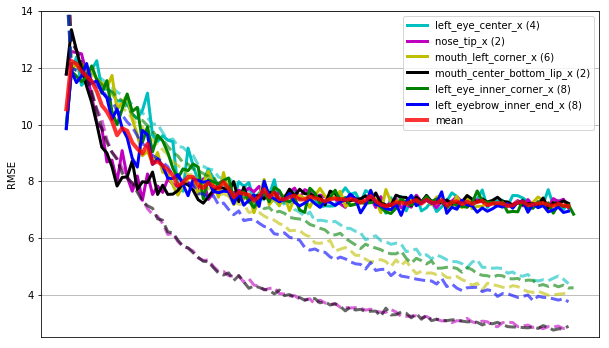

In [94]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_color_cycle(['c', 'c', 'm', 'm', 'y', 'y', 'k', 'k', 'g', 'g', 'b', 'b'])

valid_losses = []
train_losses = []

for model_number, (cg, model) in enumerate(models.items(), 1):
    valid_loss = np.array([i['valid_loss'] for i in model.train_history_])
    train_loss = np.array([i['train_loss'] for i in model.train_history_])
    valid_loss = np.sqrt(valid_loss) * 48
    train_loss = np.sqrt(train_loss) * 48
    valid_loss = rebin(valid_loss, (100,))
    train_loss = rebin(train_loss, (100,))
    valid_losses.append(valid_loss)
    train_losses.append(train_loss)
    ax.plot(valid_loss,label='{} ({})'.format(cg[0], len(cg)), linewidth=3)
    ax.plot(train_loss,linestyle='--', linewidth=3, alpha=0.6)
    ax.set_xticks([])

weights = np.array([m.output_num_units for m in models.values()],dtype=float)
weights /= weights.sum()
mean_valid_loss = (np.vstack((valid_losses[0],valid_losses[1],valid_losses[2],valid_losses[3],valid_losses[4][:100],valid_losses[5])) * weights.reshape(-1, 1)).sum(axis=0)
ax.plot(mean_valid_loss, color='r', label='mean', linewidth=4, alpha=0.8)
ax.legend()
ax.set_ylim((2.5, 14.0))
ax.grid()
plt.ylabel("RMSE")
plt.show()

### 9.9 Make predictions to submit to Kaggle

In [15]:
fname_specialists='net-specialists.pickle'
with open(fname_specialists, 'rb') as f:
    specialists = pickle.load(f)

In [46]:
X = load2d(test=True)[0]
y_pred = np.empty((X.shape[0], 30))

for model in specialists.values():
    y_pred1 = model.predict(X)
    y_pred = np.vstack([y_pred, y_pred1]) # changed from hstack to vstack to force it to run but doesn't really work
    
columns = ()
for cols in specialists.keys():
    columns += cols
    
y_pred2 = y_pred * 48 + 48
y_pred2 = y_pred2.clip(0, 96)

df = DataFrame(y_pred2, columns=columns)

lookup_table = read_csv(os.path.expanduser(FLOOKUP))
values = []

for index, row in lookup_table.iterrows():
    values.append((row['RowId'],df.ix[row.ImageId - 1][row.FeatureName],))

now_str = datetime.now().isoformat().replace(':', '-')
submission = DataFrame(values, columns=('RowId', 'Location'))
filename = 'submission-{}.csv'.format(now_str)
submission.to_csv(filename, index=False)
print("Wrote {}".format(filename))

ImageId    1783
Image      1783
dtype: int64


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Wrote submission-2017-12-03T06-49-59.417191.csv


# END OF TUTORIAL CODE


### 10. Study In-sample Training and Validation Loss

Note that this "Training" and "Validation" data came from our 1940 training examples only. The Neural Net call automatically split 0.1 of these 1940 examples internally for its validation set. This has nothing to do with our development set, which is necessary for us to later compare with other models such as SVM or Logistic Regression.

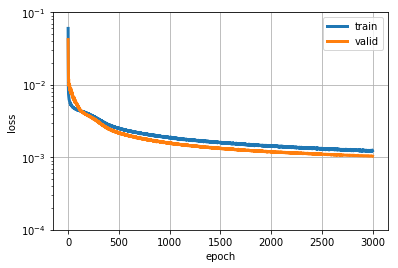

In [96]:
# object net12 keeps training history for each epoch
# we can access this record
train_loss = np.array([i["train_loss"] for i in net_pretrain.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net_pretrain.train_history_])
plt.plot(train_loss, linewidth=3, label="train")
plt.plot(valid_loss, linewidth=3, label="valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(1e-4,1e-1)
plt.yscale("log")
plt.show()

In [19]:
# Our validation error is 0.003255 here
# we need to convert this back 
np.sqrt(0.00079)*48
# now it returns a proxy value for the Kaggle board score

1.3491330549652989

### 11. Plot in-sample predictions : training set
how well does the model fit to training examples fed into it?

In [16]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap = 'gray')
    axis.scatter(y[0::2]*48+48, y[1::2]*48+48, marker='x', s=10)

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


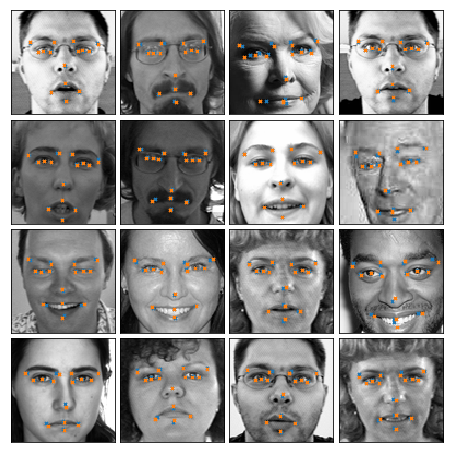

In [17]:
# load test set and predict
y_train_pred = net12.predict(X_train)

fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# predicted by model
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_train[i], y_train_pred[i], ax)

# training labels
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_train[i], y_train[i], ax)    

plt.show()

# cyan--our model prediction on training examples
# orange--real keypoints on training examples

### 12. Plot out-of-sample predictions : development set
how well does the model perform on the development set?

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


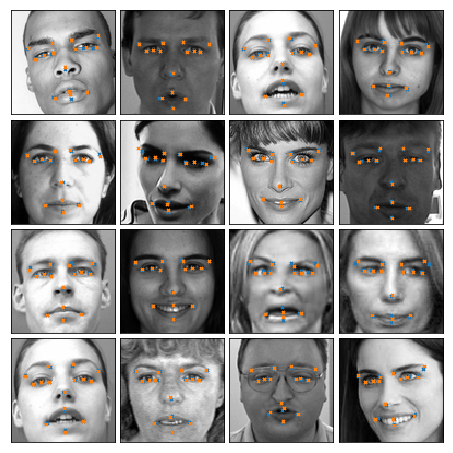

In [18]:
# load test set and predict
#X, _ = load(test=True)
y_dev_pred = net12.predict(X_dev)

fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_dev[i], y_dev_pred[i], ax)

for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_dev[i], y_dev[i], ax)
    
plt.show()

# cyan--our model prediction on development examples
# orange--real keypoints on development examples

### 12.5 Out-of-sample MSE: Development Set

In [19]:
mean_squared_error(y_dev, y_dev_pred)

0.00086455792

In [20]:
np.sqrt(mean_squared_error(y_dev, y_dev_pred))*48

1.4113615751266479

### 13. How will it look on the test set?
Note that we have no labels available, this is just a preview of how the model will perform on test set

ImageId    1783
Image      1783
dtype: int64


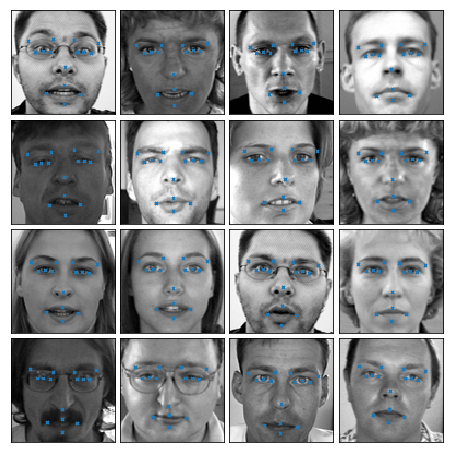

In [21]:
# load test set and predict
X_test, _ = load2d(test=True)
y_test_pred = net12.predict(X_test)

fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_test_pred[i], ax)
    
plt.show()